In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import copy
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles, make_moons, make_blobs, make_gaussian_quantiles
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import requests
from io import BytesIO

In [ ]:
! git clone https://github.com/jpospinalo/MachineLearning

Cloning into 'MachineLearning'...
remote: Enumerating objects: 195, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 195 (delta 45), reused 69 (delta 28), pack-reused 65 (from 1)
Receiving objects: 100% (195/195), 9.35 MiB | 15.96 MiB/s, done.
Resolving deltas: 100% (62/62), done.


# __1. Clasificación__

El siguiente laboratorio tiene como propósito evaluar el desempeño de modelos de clasificación. Se evaluarán datos con características no lineales y se realizará un proceso de clasificación sobre un conjunto de imágenes. A continuación se presentan algunas funciones que serán de utilidad para el desarrollo del laboratorio.

## __Obtener datos__



In [ ]:
# Carga de datos: Genera un dataset sintético con estructura no lineal (espirales)
def load_planar_dataset():
    np.random.seed(1)
    m = 400
    N = int(m/2)
    D = 2 #
    X = np.zeros((m,D))
    Y = np.zeros((m,1), dtype='uint8')
    a = 4

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    X = X.T
    Y = Y.T

    return X.T, Y.T.reshape(-1,1)

# Proporciona otros datasets como círculos ruidosos y datos gaussianos para experimentación
def load_extra_datasets():
    N = 200
    noisy_circles = sklearn.datasets.make_circles(n_samples=N, factor=.5, noise=.3)
    noisy_moons = sklearn.datasets.make_moons(n_samples=N, noise=.2)
    blobs = sklearn.datasets.make_blobs(n_samples=N, random_state=5, n_features=2, centers=6)
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.5, n_samples=N, n_features=2, n_classes=2, shuffle=True, random_state=None)
    no_structure = np.random.rand(N, 2), np.random.randint(0 , 2, 200)

    return noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure


## __Límite de decisión__

In [ ]:
# Visualización de fronteras de decisión de modelos de clasificación.
def make_meshgrid(X, y, step=.02):
    x = X[:,0]
    y = X[:,1]
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
    return xx, yy

def plot_contours(ax, clf, X, y, **params):
    xx, yy = make_meshgrid(X, y)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.coolwarm, s=50, edgecolors='k')
    ax.set_title(clf.__class__.__name__)
    out = ax.contourf(xx, yy, Z, **params)
    return out

## __Imágenes de gatos__

In [ ]:
# Función para cargar un conjunto de datos de imágenes (clasificación de gatos vs. no-gatos)
def load_cats():
    train_dataset = h5py.File('/content/MachineLearning/NN/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('/content/MachineLearning/NN/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

# __1. Datos no lineales__

El siguiente conjunto de datos presenta una estructura no lineal. El objetivo es comparar el resultado de una clasificación obtenida a través de una red neural con diferentes configuraciones de capas ocultas.

In [ ]:

X, y = load_planar_dataset()
y.shape

(400, 1)

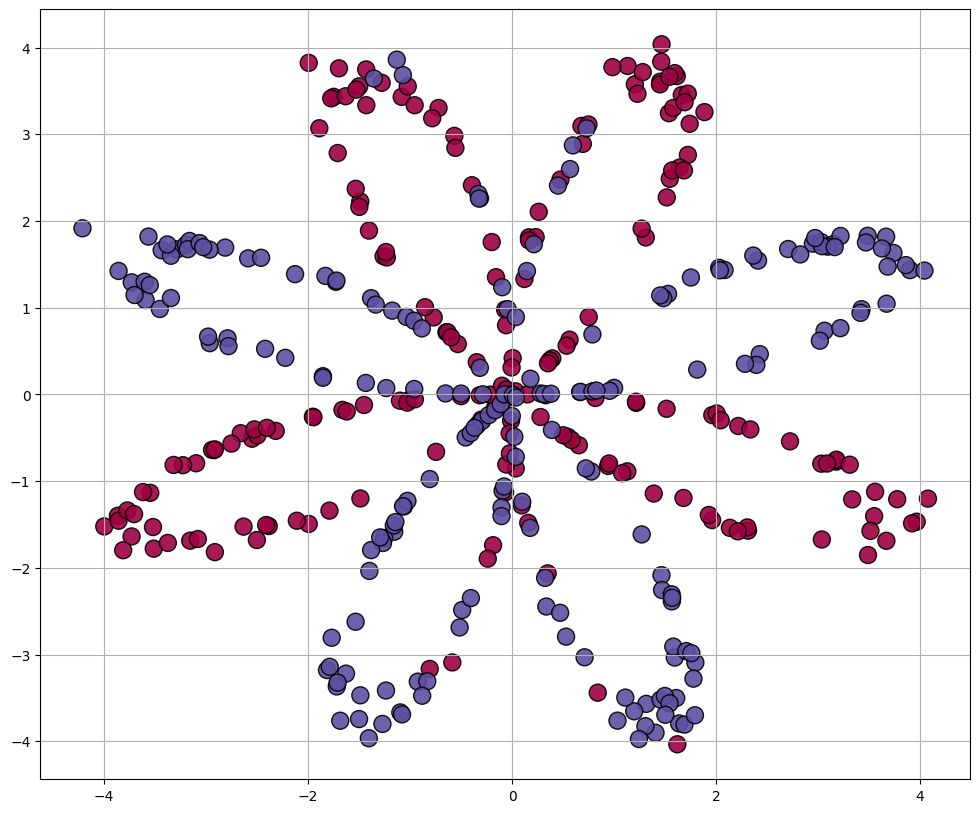

In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(X[:,0], X[:,1], c=y, s=150, edgecolor='black', alpha=0.9, cmap=plt.cm.Spectral)
plt.grid()


1. Para el conjunto de datos representado en la imagen, entrene un modelo de regresión logística y evalúe su desempeño. Visualice el límite de decisión e interprete los resultados obtenidos.




In [ ]:
# Función para visualizar los límites de decisión
def plot_contours(ax, model, X, y, plot_title=""):
    # Generar una malla de puntos
    h = .02  # Paso en la malla
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Dibujar los contornos
    ax.contourf(xx, yy, Z, alpha=0.8)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=30)
    ax.set_title(plot_title)

In [ ]:
# Generación de datos de ejemplo (puedes reemplazarlo con tu propio conjunto de datos)

X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, random_state=42)

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 1. Regresión Logística
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

Reporte de clasificación para Regresión Logística:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.90      1.00      0.95         9

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.96      0.95      0.95        20




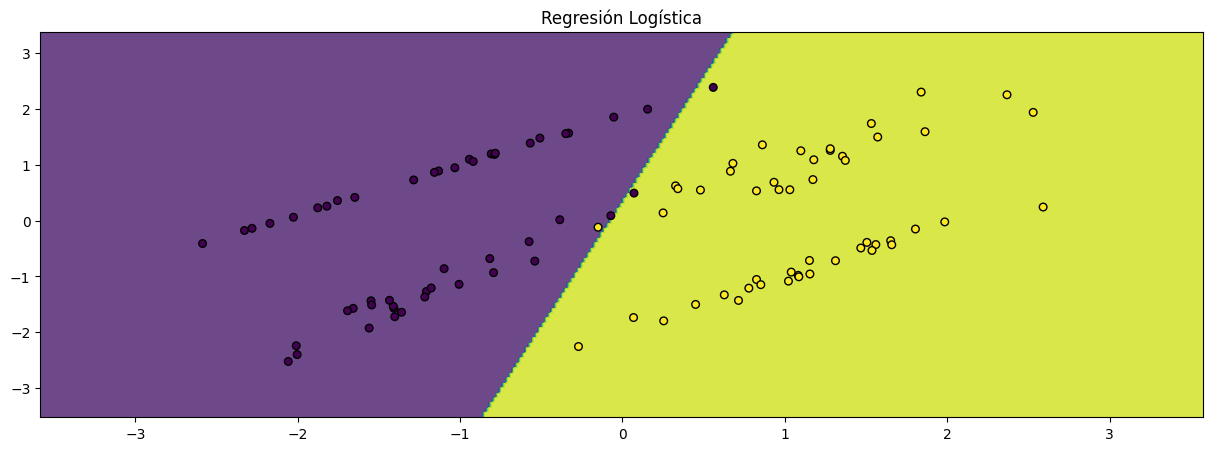

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5)) # Change this line

models = [logreg]
model_names = ['Regresión Logística']

for i, model in enumerate(models):
    plot_contours(ax, model, X, y, plot_title=model_names[i]) # Use ax instead of axes[i]
    print(f"Reporte de clasificación para {model_names[i]}:\n{classification_report(y_test, model.predict(X_test))}\n")

El modelo muestra una frontera de decisión lineal donde la probabilidad de ambas clases es igual. Los puntos oscuros y amarillos representan las clases reales, y la mayoría están correctamente clasificados, aunque algunos errores son visibles donde los puntos caen en la región opuesta. Esto indica que el modelo asume una buena linealidad y clasifica adecuadamente en general los datos.

2. Entrene dos nuevos modelos utilizando K-Nearest Neighbors (KNN) y Random Forest.


In [ ]:
# 2. KNN
knn = KNeighborsClassifier(n_neighbors=5) # Experimenta con diferentes valores de n_neighbors
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

# 3. Random Forest
rf = RandomForestClassifier(n_estimators=100) # Experimenta con diferentes valores de n_estimators
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

Reporte de clasificación para KNN:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         9

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20


Reporte de clasificación para Random Forest:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.90      1.00      0.95         9

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.96      0.95      0.95        20




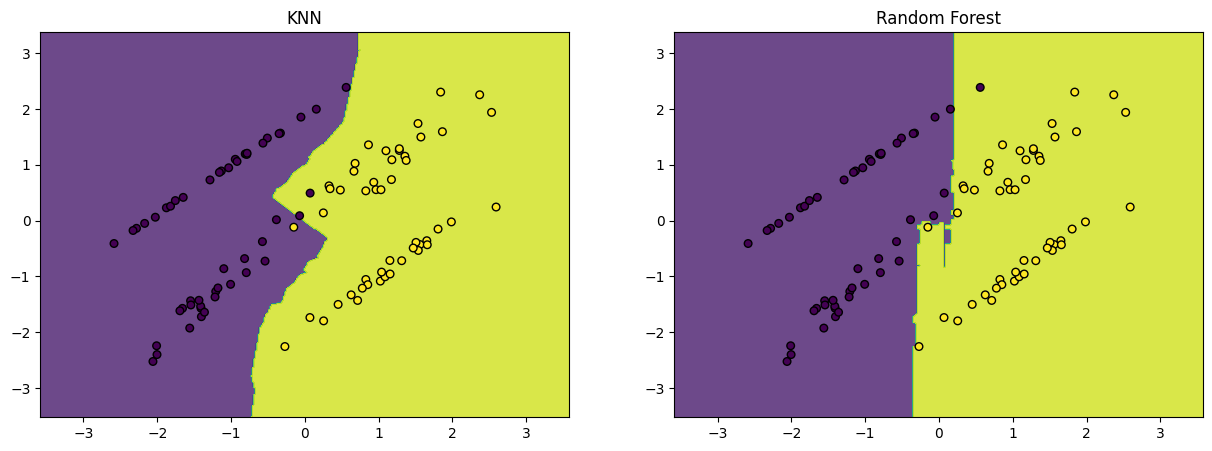

In [ ]:
# 4. Visualización y reporte de clasificación
models = [knn, rf]
model_names = ['KNN', 'Random Forest']

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i, model in enumerate(models):
    plot_contours(axes[i], model, X, y, plot_title=model_names[i])
    print(f"Reporte de clasificación para {model_names[i]}:\n{classification_report(y_test, model.predict(X_test))}\n")

3. Experimente variando el número de vecinos en KNN y el número de estimadores en Random Forest. Explique el impacto de estos parámetros

In [ ]:
# 2. KNN
knn2 = KNeighborsClassifier(n_neighbors=2) # Experimenta con diferentes valores de n_neighbors
knn2.fit(X_train, y_train)
y_pred_knn2 = knn2.predict(X_test)

# 3. Random Forest
rf2 = RandomForestClassifier(n_estimators=3) # Experimenta con diferentes valores de n_estimators
rf2.fit(X_train, y_train)
y_pred_rf2 = rf2.predict(X_test)

Reporte de clasificación para KNN:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         9

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20


Reporte de clasificación para Random Forest:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        11
           1       0.89      0.89      0.89         9

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20




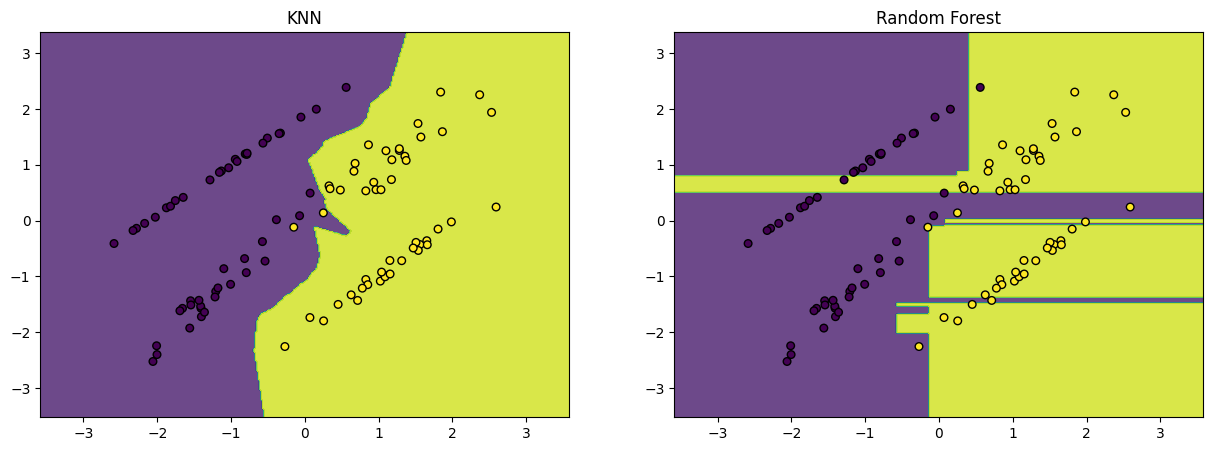

In [ ]:
# 4. Visualización y reporte de clasificación
models = [knn2, rf2]
model_names = ['KNN', 'Random Forest']

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i, model in enumerate(models):
    plot_contours(axes[i], model, X, y, plot_title=model_names[i])
    print(f"Reporte de clasificación para {model_names[i]}:\n{classification_report(y_test, model.predict(X_test))}\n")

En la comparación entre KNN (
𝑘
=
2
) y Random Forest (3 estimadores), las regiones de decisión del modelo KNN son altamente flexibles y se adaptan estrechamente a los datos, lo que lo hace eficaz para detectar patrones complejos, pero también lo vuelve sensible al ruido y al sobreajuste. En contraste, Random Forest, con su enfoque basado en la combinación de múltiples árboles, presenta regiones de decisión más discretas y robustas frente al ruido, aunque con un número limitado de estimadores, como en este caso, puede carecer de precisión para capturar patrones complejos.

Mientras que un
𝑘
 pequeño en KNN produce límites detallados pero propensos a errores locales, un mayor
𝑘
k suaviza las fronteras y mejora la generalización. Del mismo modo, en Random Forest, aumentar el número de estimadores genera predicciones más estables y precisas al reducir la varianza del modelo. En este caso, ambos modelos están configurados de forma que limitan su robustez, con KNN favoreciendo la flexibilidad lo que esta produciendo un sobre ajuste por la simplicidad en los datos y Random Forest la simplicidad ya que no logra una buena clasificacion por la cantidad de estimadores.

4. En todos los casos, visualice los límites de decisión y genere un reporte de clasificación detallado.


Reporte de clasificación para Regresión Logística:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.90      1.00      0.95         9

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.96      0.95      0.95        20


Reporte de clasificación para KNN:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         9

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20


Reporte de clasificación para Random Forest:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.90      1.00      0.95         9

    accuracy                           0.95      

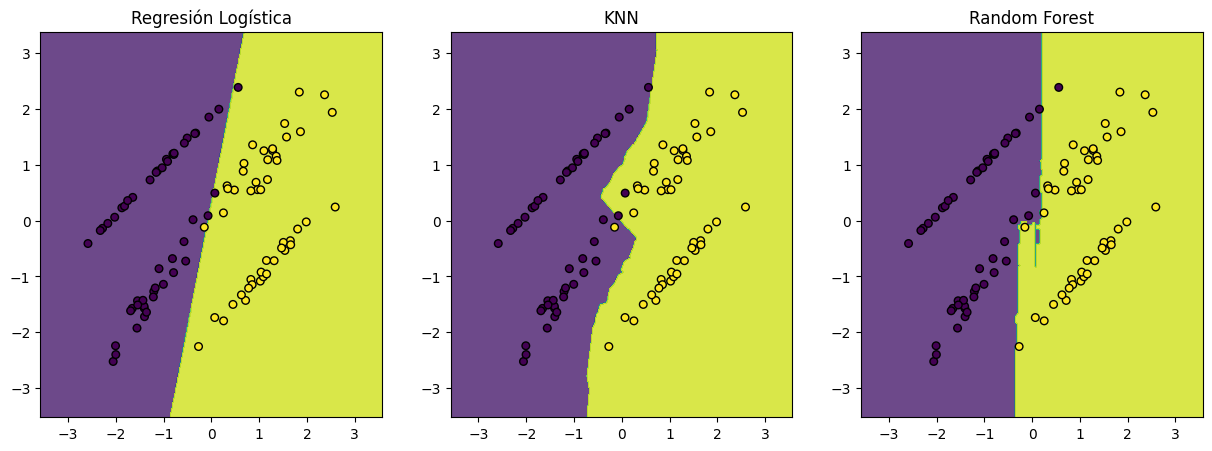

In [ ]:
# 4. Visualización y reporte de clasificación
models = [logreg, knn, rf]
model_names = ['Regresión Logística', 'KNN', 'Random Forest']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, model in enumerate(models):
    plot_contours(axes[i], model, X, y, plot_title=model_names[i])
    print(f"Reporte de clasificación para {model_names[i]}:\n{classification_report(y_test, model.predict(X_test))}\n")



La comparación entre Regresión Logística, KNN y Random Forest revela diferencias significativas en cómo cada modelo maneja la complejidad de los datos. La Regresión Logística genera límites lineales, adecuados para datos separables de forma simple, pero insuficientes para estructuras no lineales. KNN por ejemplo en este caso con k = 2 captura patrones locales complejos gracias a sus límites de decisión no lineales, aunque es propenso al ruido y al sobreajuste y esto se debe a la simplicidad de los datos. Random Forest por otro lado ofrece un equilibrio entre robustez y flexibilidad como se muestra en la anterior grafica con 100 estimadores, pero que, con solo 3 árboles, carecen de precisión para patrones complejos..





5. Construya una curva ROC para comparar el desempeño de todos los modelos generados y seleccione aquel con la mayor capacidad predictiva.

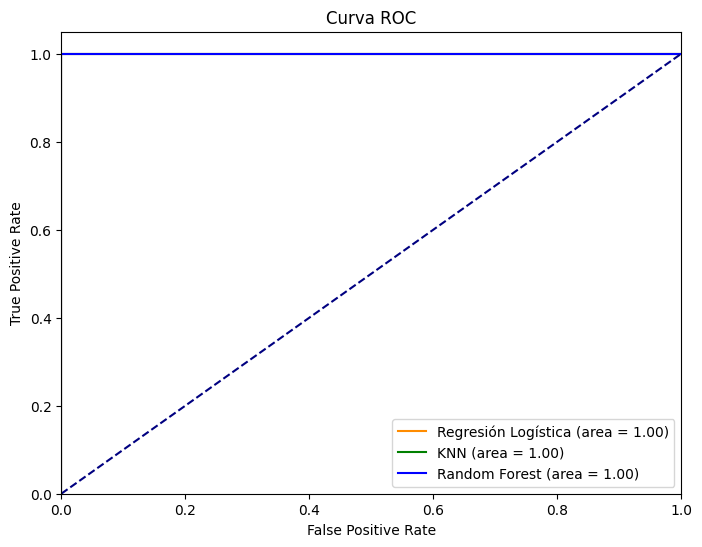

In [ ]:
# 5. Curva ROC
plt.figure(figsize=(8,6))

# Regresión Logística
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)
plt.plot(fpr_logreg, tpr_logreg, color='darkorange', label=f'Regresión Logística (area = {roc_auc_logreg:.2f})')

# KNN
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn.predict_proba(X_test)[:,1])
roc_auc_knn = auc(fpr_knn, tpr_knn)
plt.plot(fpr_knn, tpr_knn, color='green', label=f'KNN (area = {roc_auc_knn:.2f})')

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, color='blue', label=f'Random Forest (area = {roc_auc_rf:.2f})')

# Plot de la línea diagonal
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


Los 3 modelos ofrecen los mismo resultados segun el analisis de la curva ROC. Sin embargo, teniendo en cuenta las graficas anteriores y teniendo en cuenta lo simple que son los datos se recomienda utilizar la regresion logistica para este problema ya que es el modelo menos complejo gracias a los limites de decision lineales suficientes para la clasificacion.

5. Repita el mismo procedimiento para los conjuntos de datos disponibles a través de la función `load_extra_datasets()`

### Resultados para el conjunto de datos: Noisy Circles ###
Reporte de clasificación para Regresión Logística en Noisy Circles:
              precision    recall  f1-score   support

           0       0.46      0.41      0.43       100
           1       0.46      0.51      0.49       100

    accuracy                           0.46       200
   macro avg       0.46      0.46      0.46       200
weighted avg       0.46      0.46      0.46       200


Reporte de clasificación para KNN en Noisy Circles:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       100
           1       0.97      0.98      0.98       100

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200


Reporte de clasificación para Random Forest en Noisy Circles:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95    

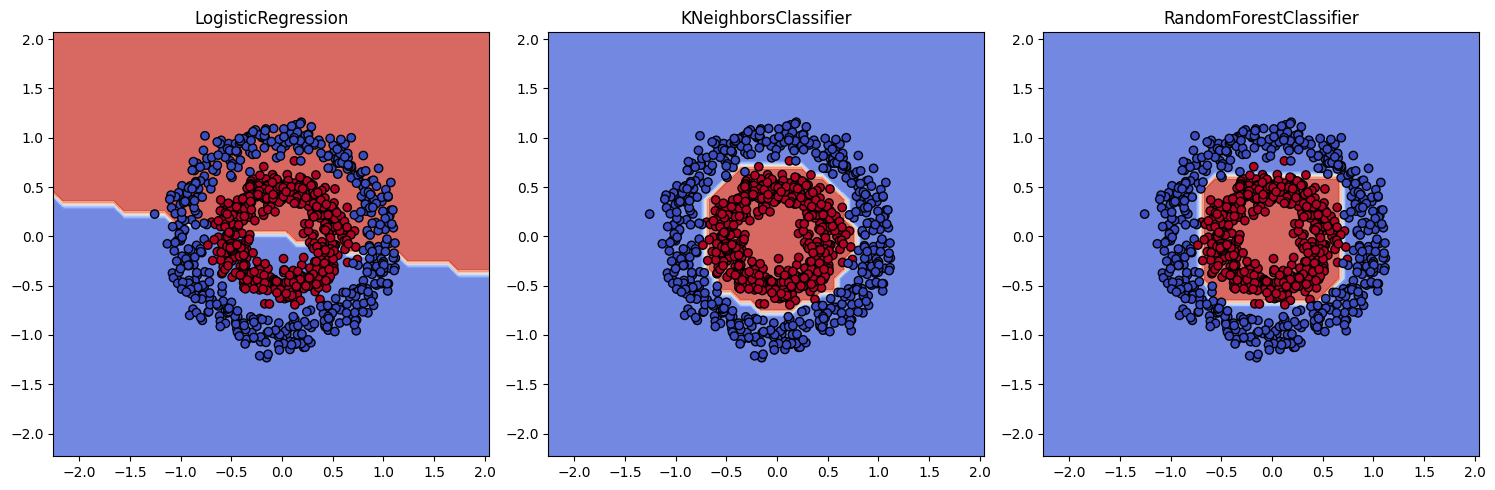

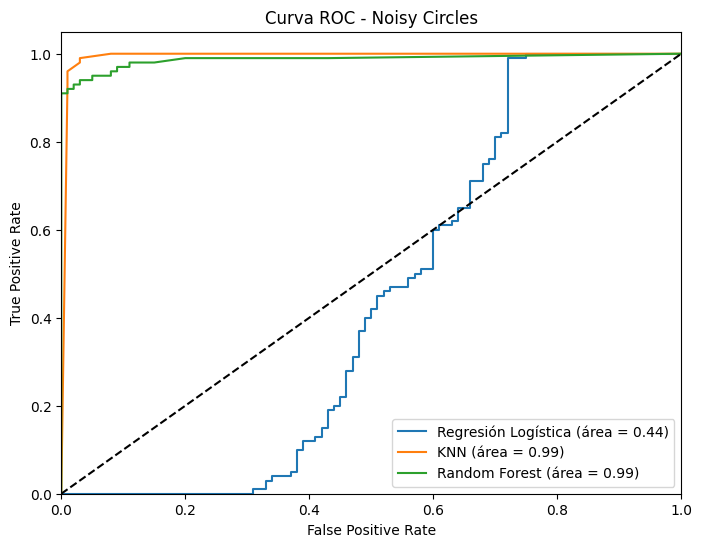

### Resultados para el conjunto de datos: Noisy Moons ###
Reporte de clasificación para Regresión Logística en Noisy Moons:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       100
           1       0.86      0.86      0.86       100

    accuracy                           0.86       200
   macro avg       0.86      0.86      0.86       200
weighted avg       0.86      0.86      0.86       200


Reporte de clasificación para KNN en Noisy Moons:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       100
           1       0.98      0.97      0.97       100

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200


Reporte de clasificación para Random Forest en Noisy Moons:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       100
 

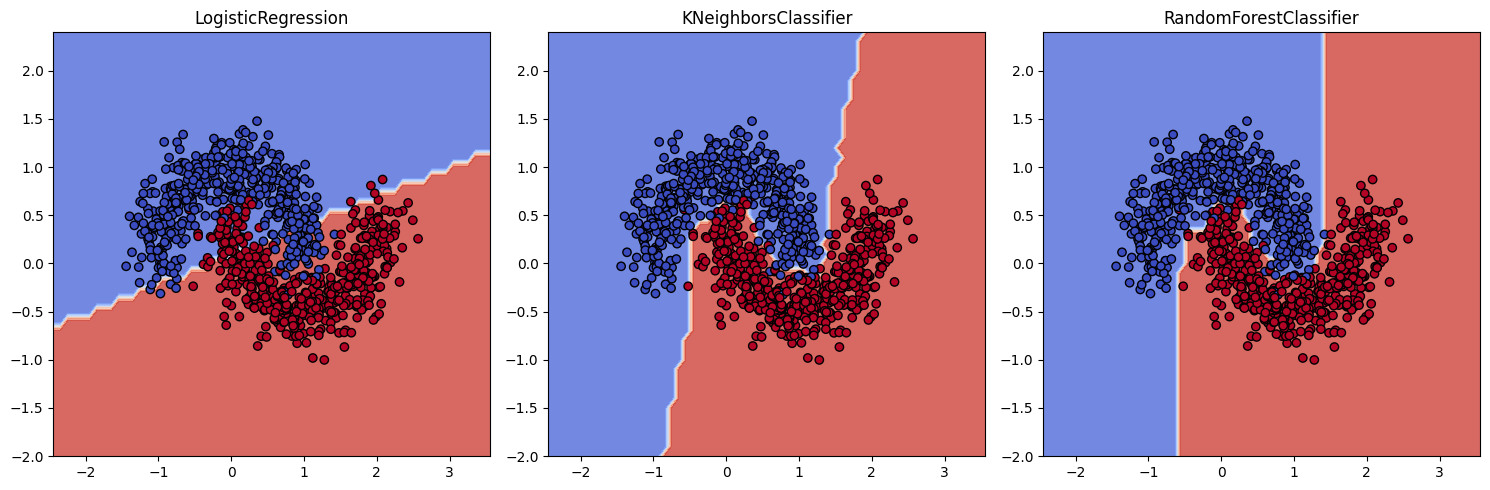

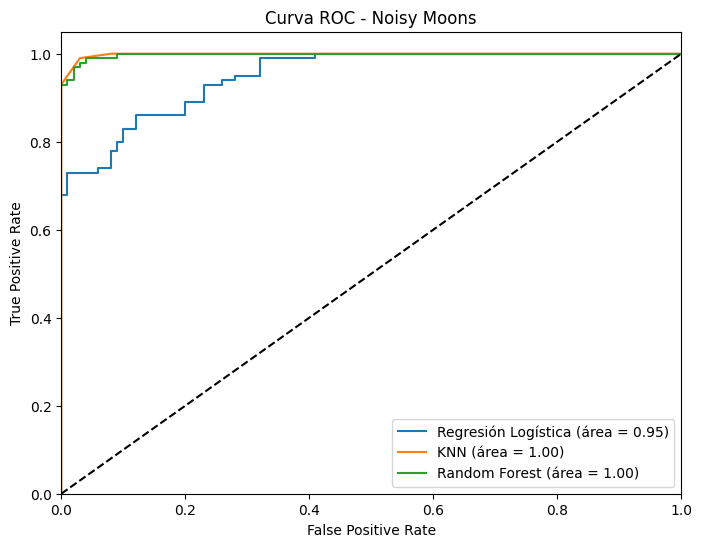

### Resultados para el conjunto de datos: Blobs ###
Reporte de clasificación para Regresión Logística en Blobs:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       103
           1       1.00      1.00      1.00        97

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


Reporte de clasificación para KNN en Blobs:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       103
           1       1.00      1.00      1.00        97

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


Reporte de clasificación para Random Forest en Blobs:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       103
           1       1.00  

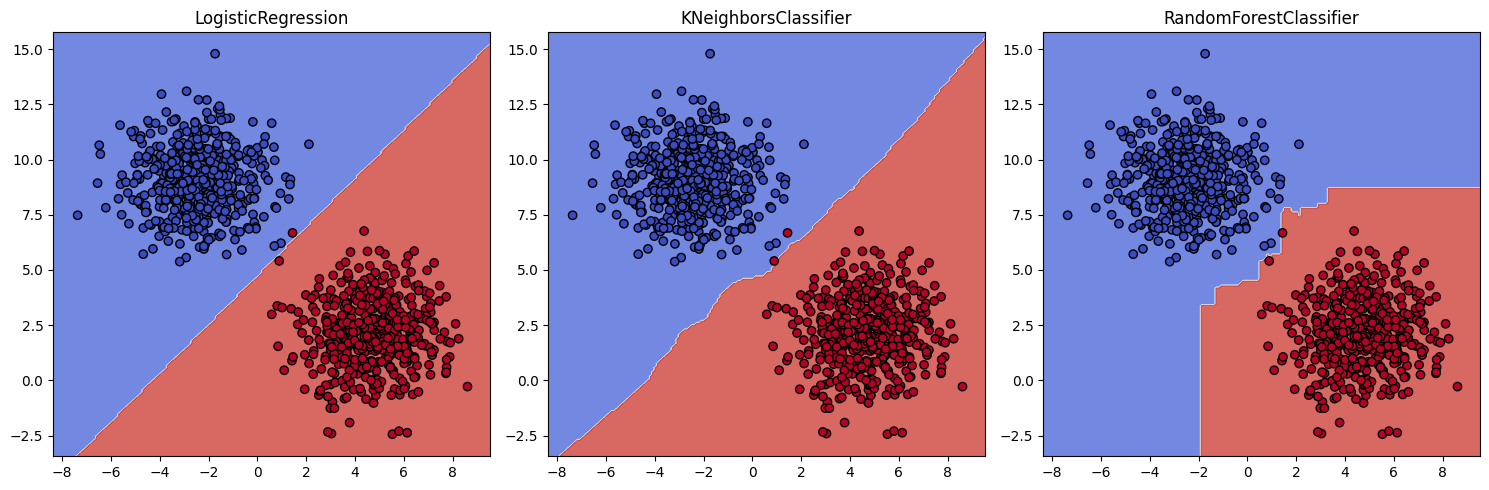

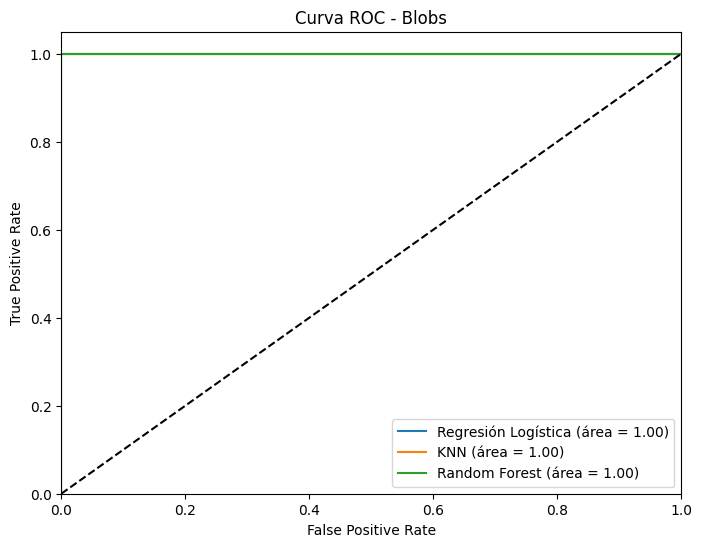

### Resultados para el conjunto de datos: Gaussian Quantiles ###
Reporte de clasificación para Regresión Logística en Gaussian Quantiles:
              precision    recall  f1-score   support

           0       0.54      0.54      0.54       104
           1       0.51      0.51      0.51        96

    accuracy                           0.53       200
   macro avg       0.52      0.52      0.52       200
weighted avg       0.53      0.53      0.53       200


Reporte de clasificación para KNN en Gaussian Quantiles:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       104
           1       0.97      0.96      0.96        96

    accuracy                           0.96       200
   macro avg       0.97      0.96      0.96       200
weighted avg       0.97      0.96      0.96       200


Reporte de clasificación para Random Forest en Gaussian Quantiles:
              precision    recall  f1-score   support

           0       0.96    

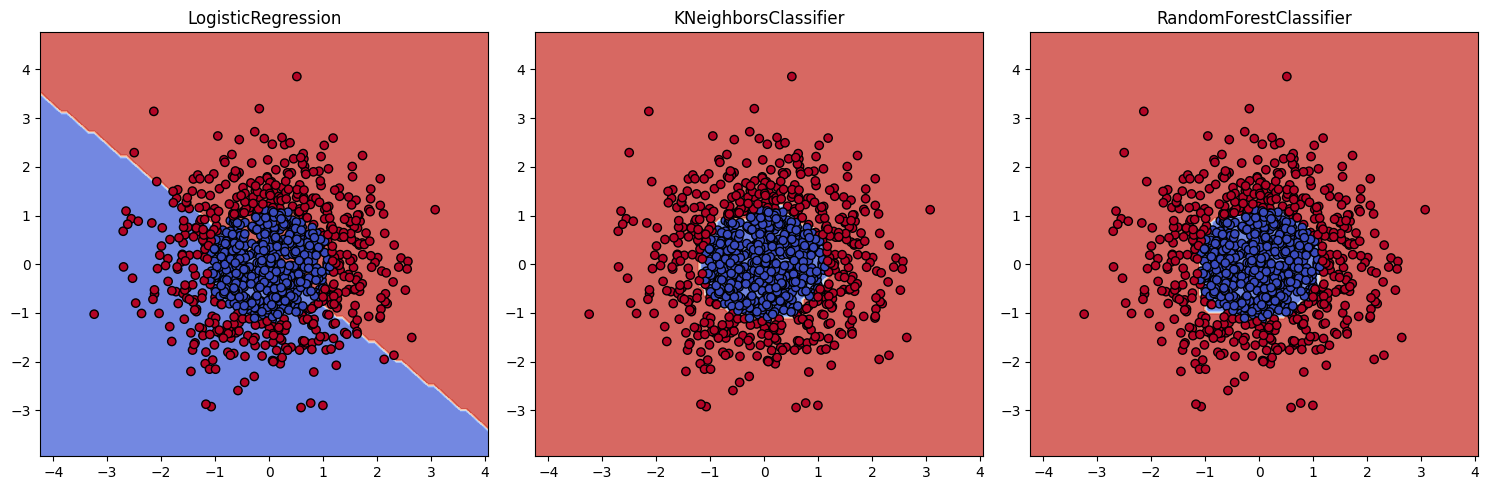

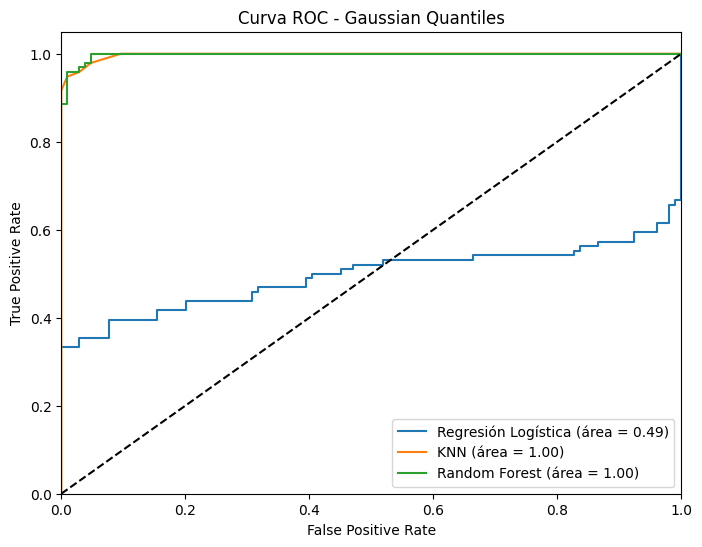

### Resultados para el conjunto de datos: No Structure ###
Reporte de clasificación para Regresión Logística en No Structure:
              precision    recall  f1-score   support

           0       0.47      0.78      0.59        97
           1       0.45      0.17      0.24       103

    accuracy                           0.47       200
   macro avg       0.46      0.47      0.41       200
weighted avg       0.46      0.47      0.41       200


Reporte de clasificación para KNN en No Structure:
              precision    recall  f1-score   support

           0       0.50      0.54      0.52        97
           1       0.54      0.50      0.52       103

    accuracy                           0.52       200
   macro avg       0.52      0.52      0.52       200
weighted avg       0.52      0.52      0.52       200


Reporte de clasificación para Random Forest en No Structure:
              precision    recall  f1-score   support

           0       0.48      0.61      0.53        

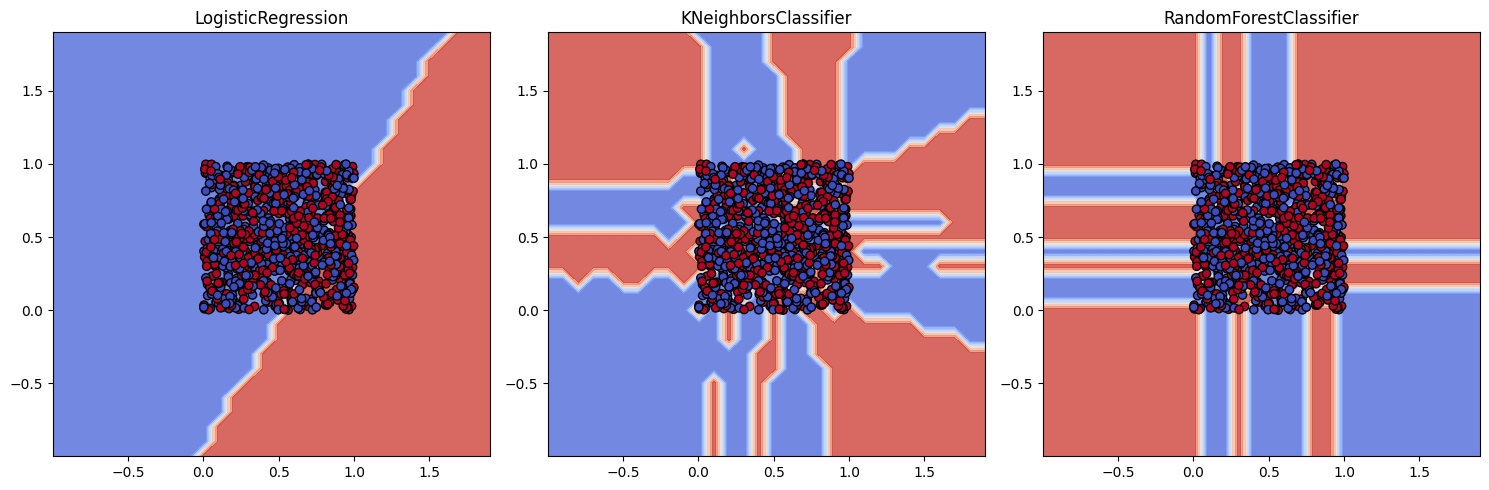

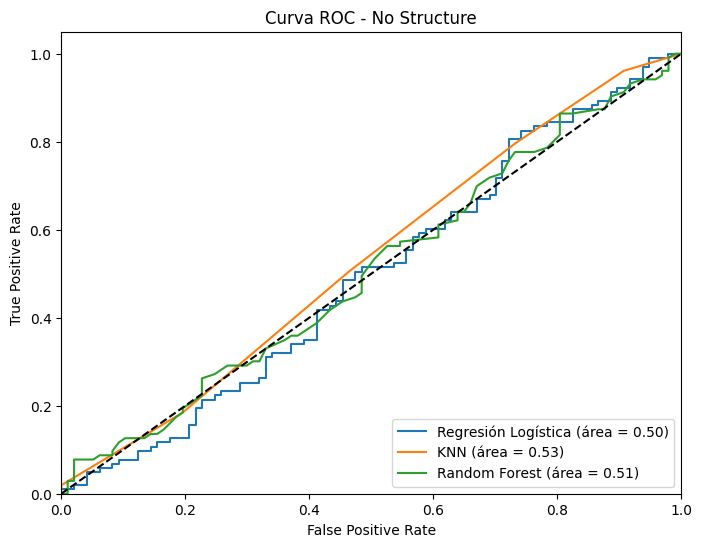

In [ ]:
# Función para cargar datasets
def load_extra_datasets():
    datasets = [
        make_circles(n_samples=1000, factor=0.5, noise=0.1, random_state=42),
        make_moons(n_samples=1000, noise=0.2, random_state=42),
        make_blobs(n_samples=1000, centers=2, random_state=42, cluster_std=1.5),
        make_gaussian_quantiles(n_samples=1000, n_features=2, n_classes=2, random_state=42),
        (np.random.rand(1000, 2), np.random.randint(0, 2, 1000)),  # No estructura
    ]
    return datasets

# Función para visualizar contornos de decisión
def plot_contours(ax, model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.coolwarm)
    ax.set_title(type(model).__name__)

# Cargar los datasets
datasets = load_extra_datasets()
dataset_names = ['Noisy Circles', 'Noisy Moons', 'Blobs', 'Gaussian Quantiles', 'No Structure']

# Modelos y nombres
models = [LogisticRegression(), KNeighborsClassifier(n_neighbors=5), RandomForestClassifier(n_estimators=100)]
model_names = ['Regresión Logística', 'KNN', 'Random Forest']

# Iterar sobre los datasets
for i, (X, y) in enumerate(datasets):
    print(f"### Resultados para el conjunto de datos: {dataset_names[i]} ###")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for j, model in enumerate(models):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        print(f"Reporte de clasificación para {model_names[j]} en {dataset_names[i]}:\n{classification_report(y_test, y_pred)}\n")
        plot_contours(axes[j], model, X, y)

    plt.tight_layout()
    plt.show()

    # Curvas ROC
    plt.figure(figsize=(8, 6))
    for model, model_name in zip(models, model_names):
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_score)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{model_name} (área = {roc_auc:.2f})')
        else:
            print(f"{model_name} no soporta predict_proba para ROC.")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Curva ROC - {dataset_names[i]}')
    plt.legend(loc="lower right")
    plt.show()


# __2. Clasificador para gatos__

El objetivo es generar un modelo que permita identificar gatos de un conjunto de imágenes. La siguiente línea carga los conjuntos de datos de prueba y entrenamiento. Los datos disponibles cuentan con los tres canales.

<center>

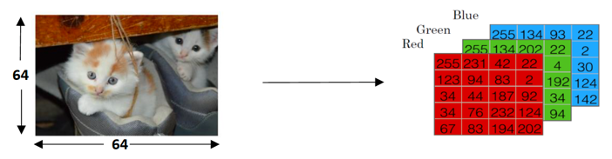

</center>

In [ ]:
#Cargar el conjunto de datos
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_cats()

print('Train size:', train_set_x_orig.shape)
print('Test size:', test_set_x_orig.shape)

Train size: (209, 64, 64, 3)
Test size: (50, 64, 64, 3)


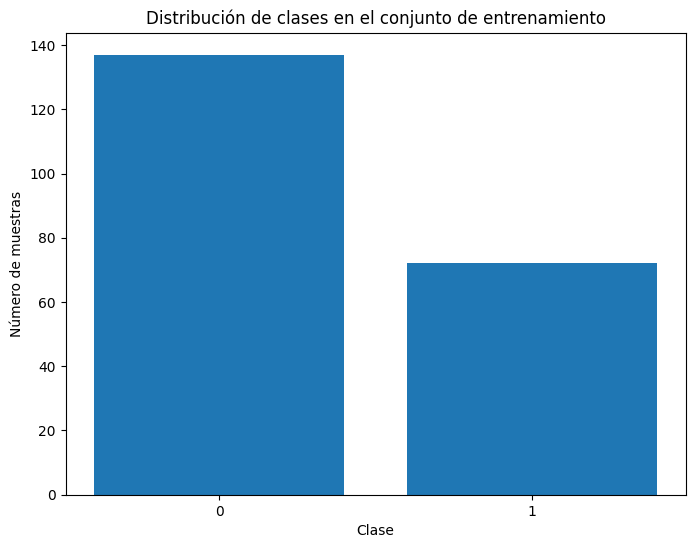

In [ ]:
unique, counts = np.unique(train_set_y, return_counts=True)
plt.figure(figsize=(8,6))
plt.bar(unique, counts)
plt.xticks(unique)
plt.xlabel('Clase')
plt.ylabel('Número de muestras')
plt.title('Distribución de clases en el conjunto de entrenamiento')
plt.show()

In [ ]:
test_set_y

array([[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 0]])

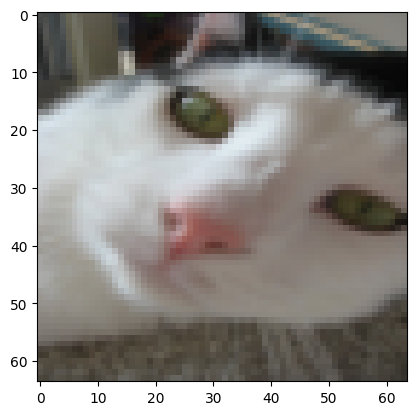

In [ ]:
plt.imshow(train_set_x_orig[14])


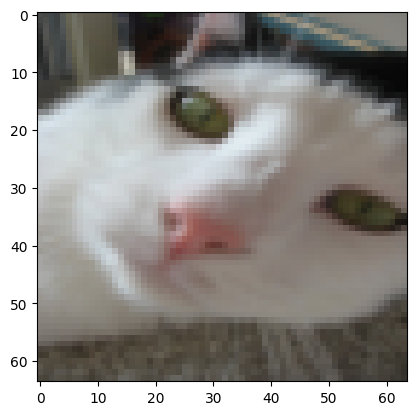

In [ ]:
x =train_set_x_orig[14].flatten()
plt.imshow(x.reshape(64, 64, 3))

Es posible visualizar las imágenes disponibles cambiando el valor de la variable `index`. Por ejemplo, el registro `14` es un gato

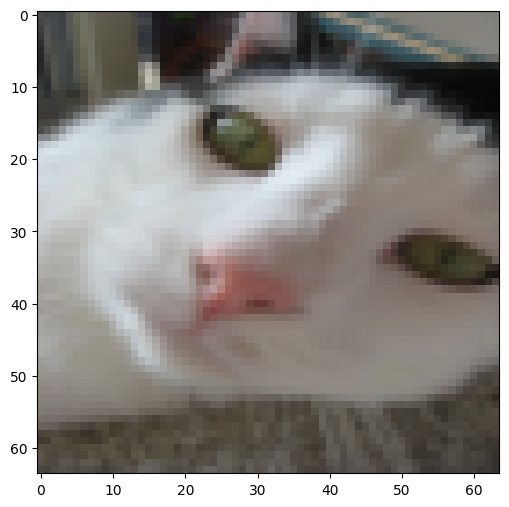

In [ ]:
index = 14
plt.figure(figsize=(6,6))
plt.imshow(train_set_x_orig[index])
plt.show()

Mientras el registro `120` no lo es.

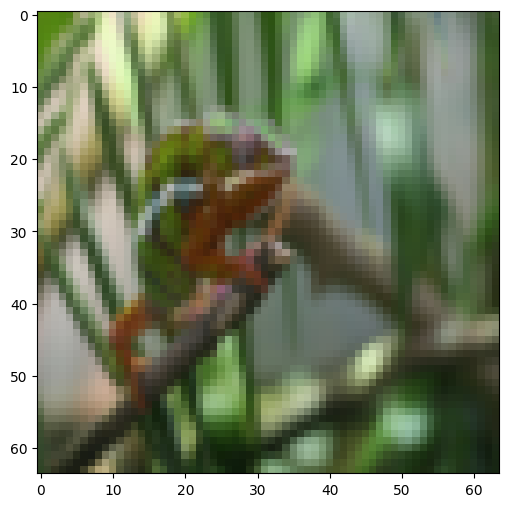

In [ ]:
index = 120
plt.figure(figsize=(6,6))
plt.imshow(train_set_x_orig[index])
plt.show()

1. Implemente  un clasificador para identificar gatos en imágenes. Experimente con diferentes modelos y compare su desempeño."



In [ ]:
# Flattening (aplanar las imágenes) - Redimensionar las imagenes
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

# Normalización (entre 0 y 1)
train_set_x = train_set_x_flatten / 255.0
test_set_x = test_set_x_flatten / 255.0


In [ ]:
# Regresión logistica
# Crear el modelo
clf = LogisticRegression()

# Entrenar el modelo
clf.fit(train_set_x.T, train_set_y.T.ravel())

# Predicciones
train_predictions = clf.predict(train_set_x.T)
test_predictions = clf.predict(test_set_x.T)

# Evaluación del modelo
print("Resumen con Regresion logistica:")
print(classification_report(test_set_y.T, clf.predict(test_set_x.T)))


Resumen con Regresion logistica:
              precision    recall  f1-score   support

           0       0.57      0.76      0.65        17
           1       0.85      0.70      0.77        33

    accuracy                           0.72        50
   macro avg       0.71      0.73      0.71        50
weighted avg       0.75      0.72      0.73        50



In [ ]:
# Experimentar con diferentes modelos
from sklearn.svm import SVC

svm_clf = SVC(kernel='linear')
svm_clf.fit(train_set_x.T, train_set_y.T.ravel())
print("Resumen con SVM:")
print(classification_report(test_set_y.T, svm_clf.predict(test_set_x.T)))

Resumen con SVM:
              precision    recall  f1-score   support

           0       0.57      0.76      0.65        17
           1       0.85      0.70      0.77        33

    accuracy                           0.72        50
   macro avg       0.71      0.73      0.71        50
weighted avg       0.75      0.72      0.73        50



In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(train_set_x.T, train_set_y.T.ravel())
print("Resumen con Random Forest:")
print(classification_report(test_set_y.T, rf_clf.predict(test_set_x.T)))

Resumen con Random Forest:
              precision    recall  f1-score   support

           0       0.43      0.94      0.59        17
           1       0.92      0.36      0.52        33

    accuracy                           0.56        50
   macro avg       0.68      0.65      0.56        50
weighted avg       0.76      0.56      0.55        50




Logistic Regression Predictions:
Image 1: Predicted 1, Actual 1


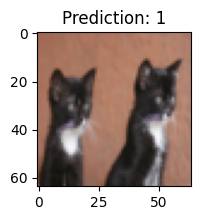

Image 2: Predicted 1, Actual 1


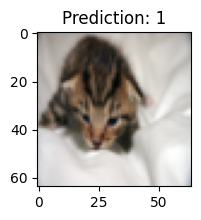

Image 3: Predicted 1, Actual 1


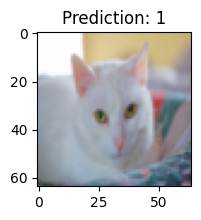

Image 4: Predicted 1, Actual 1


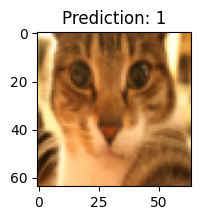

Image 5: Predicted 1, Actual 1


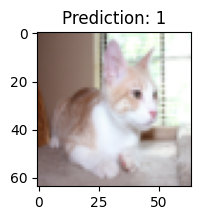

Image 6: Predicted 0, Actual 0


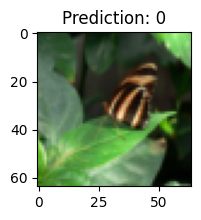

Image 7: Predicted 0, Actual 1


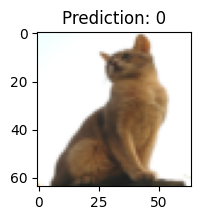

Image 8: Predicted 1, Actual 1


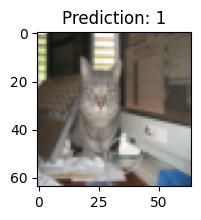

Image 9: Predicted 1, Actual 1


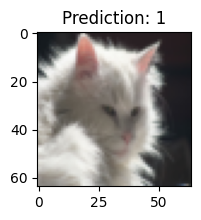

Image 10: Predicted 1, Actual 1


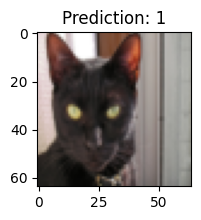


SVM Predictions:
Image 1: Predicted 1, Actual 1


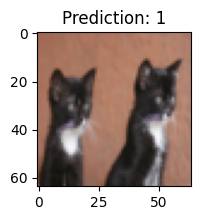

Image 2: Predicted 1, Actual 1


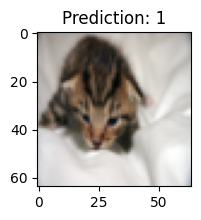

Image 3: Predicted 1, Actual 1


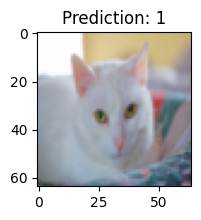

Image 4: Predicted 1, Actual 1


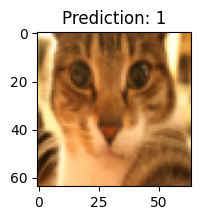

Image 5: Predicted 1, Actual 1


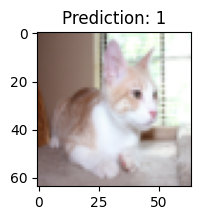

Image 6: Predicted 0, Actual 0


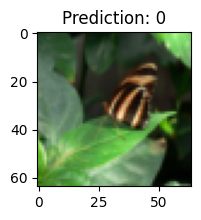

Image 7: Predicted 0, Actual 1


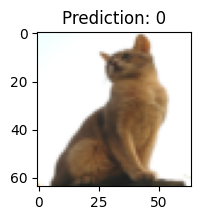

Image 8: Predicted 1, Actual 1


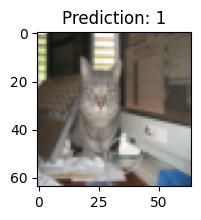

Image 9: Predicted 1, Actual 1


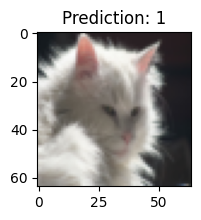

Image 10: Predicted 1, Actual 1


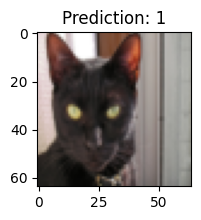


Random Forest Predictions:
Image 1: Predicted 0, Actual 1


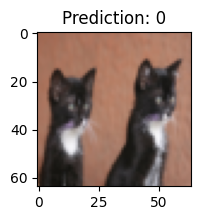

Image 2: Predicted 0, Actual 1


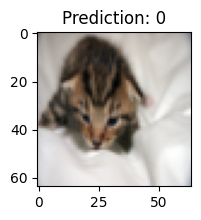

Image 3: Predicted 0, Actual 1


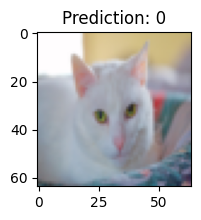

Image 4: Predicted 0, Actual 1


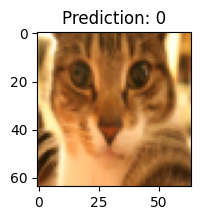

Image 5: Predicted 1, Actual 1


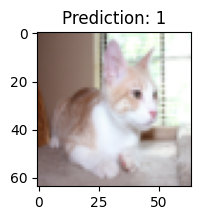

Image 6: Predicted 0, Actual 0


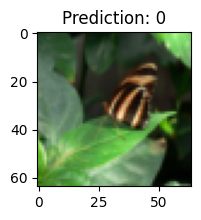

Image 7: Predicted 1, Actual 1


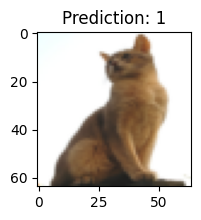

Image 8: Predicted 1, Actual 1


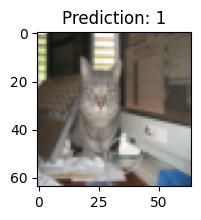

Image 9: Predicted 1, Actual 1


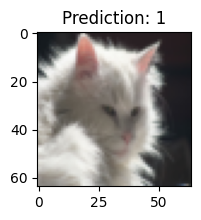

Image 10: Predicted 0, Actual 1


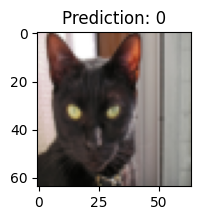

In [ ]:
print("\nLogistic Regression Predictions:")
for i in range(10):  # Show predictions for the first 5 test images
    prediction = clf.predict(test_set_x[:, i].reshape(1, -1))
    print(f"Image {i+1}: Predicted {prediction[0]}, Actual {test_set_y[0,i]}")
    plt.figure(figsize=(2,2))
    plt.imshow(test_set_x_orig[i])
    plt.title(f"Prediction: {prediction[0]}")
    plt.show()


# SVM predictions
print("\nSVM Predictions:")
for i in range(10):
    prediction = svm_clf.predict(test_set_x[:, i].reshape(1, -1))
    print(f"Image {i+1}: Predicted {prediction[0]}, Actual {test_set_y[0,i]}")
    plt.figure(figsize=(2,2))
    plt.imshow(test_set_x_orig[i])
    plt.title(f"Prediction: {prediction[0]}")
    plt.show()


# Random Forest predictions
print("\nRandom Forest Predictions:")
for i in range(10):
    prediction = rf_clf.predict(test_set_x[:, i].reshape(1, -1))
    print(f"Image {i+1}: Predicted {prediction[0]}, Actual {test_set_y[0,i]}")
    plt.figure(figsize=(2,2))
    plt.imshow(test_set_x_orig[i])
    plt.title(f"Prediction: {prediction[0]}")
    plt.show()

2. Cada miembro del grupo debe tomarse una foto, redimensionarla a un tamaño de `64x64` píxeles y realizar una predicción utilizando el modelo generado previamente.

Predicción: No es un gato


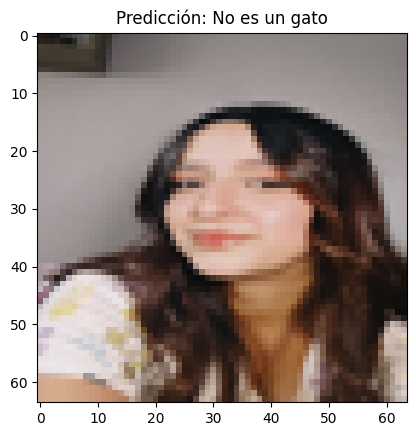

In [ ]:
from PIL import Image
import numpy as np

# Cargar imagen
my_image = "/content/isa2.jpeg"
img = Image.open(my_image).resize((64, 64))

# Convertir a numpy array y normalizar
img_array = np.array(img).reshape(1, -1).T / 255.0

prediction = clf.predict(img_array.T)
print("Predicción:", "Gato" if prediction[0] == 1 else "No es un gato")

plt.imshow(np.array(img).reshape(64, 64, 3))
plt.title(f"Predicción: {'Gato' if prediction[0] == 1 else 'No es un gato'}")
plt.show()



Predicción: No es un gato


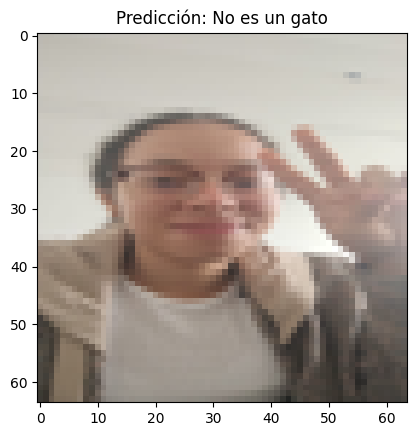

In [ ]:
# Cargar imagen
my_image2 = "/content/Andreita3.jpeg"
img2 = Image.open(my_image2).resize((64, 64))

# Convertir a numpy array y normalizar
img_array2 = np.array(img2).reshape(1, -1).T / 255.0

prediction2 = clf.predict(img_array2.T)
print("Predicción:", "Gato" if prediction2[0] == 1 else "No es un gato")

plt.imshow(np.array(img2).reshape(64, 64, 3))
plt.title(f"Predicción: {'Gato' if prediction2[0] == 1 else 'No es un gato'}")
plt.show()



Predicción: No es un gato


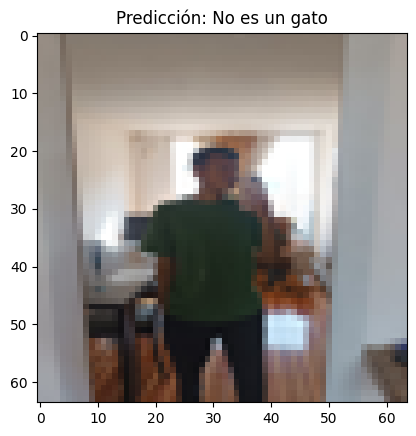

In [ ]:
# Cargar imagen
my_image3 = "/content/Miguel.jpeg"
img3 = Image.open(my_image3).resize((64, 64))

# Convertir a numpy array y normalizar
img_array3 = np.array(img3).reshape(1, -1).T / 255.0

prediction3 = clf.predict(img_array3.T)
print("Predicción:", "Gato" if prediction3[0] == 1 else "No es un gato")

plt.imshow(np.array(img3).reshape(64, 64, 3))
plt.title(f"Predicción: {'Gato' if prediction3[0] == 1 else 'No es un gato'}")
plt.show()



Predicción: No es un gato


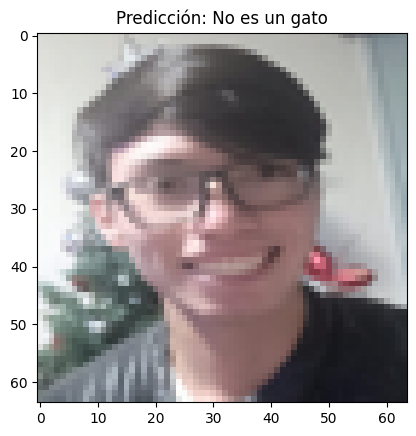

In [ ]:
# Cargar imagen
my_image4 = "/content/mitchell.jpg"
img4 = Image.open(my_image4).resize((64, 64))

# Convertir a numpy array y normalizar
img_array4 = np.array(img4).reshape(1, -1).T / 255.0

prediction4 = clf.predict(img_array4.T)
print("Predicción:", "Gato" if prediction4[0] == 1 else "No es un gato")

plt.imshow(np.array(img4).reshape(64, 64, 3))
plt.title(f"Predicción: {'Gato' if prediction4[0] == 1 else 'No es un gato'}")
plt.show()

Predicción: Gato


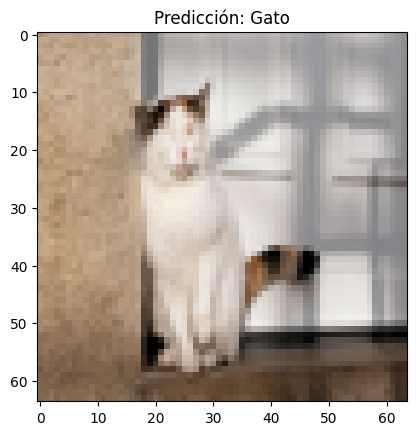

In [ ]:
def load_image_from_url(image_url):
    try:
        response = requests.get(image_url, stream=True)
        response.raise_for_status()  # Raise an exception for bad status codes
        image = Image.open(BytesIO(response.content))
        return image
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image: {e}")
        return None

# Example usage
image_url = "https://es.mypet.com/wp-content/uploads/sites/23/2022/03/ES_2022_CABU_POST_BLOG_NLDAZ-_GATOS-FUERA-DE-CASA_FEB22_TKF_01.jpeg"  # Replace with your image URL
image = load_image_from_url(image_url)

if image:
    # Resize the image to 64x64 pixels
    image = image.resize((64, 64))

    # Convert to numpy array and normalize
    img_array = np.array(image).reshape(1, -1).T / 255.0

    # Make prediction (assuming clf is your trained model)
    prediction = svm_clf.predict(img_array.T)
    print("Predicción:", "Gato" if prediction[0] == 1 else "No es un gato")

    plt.imshow(np.array(image).reshape(64, 64, 3))
    plt.title(f"Predicción: {'Gato' if prediction[0] == 1 else 'No es un gato'}")
    plt.show()

In [ ]:
from PIL import Image
import numpy as np

# Cargar la imagen
img_path2 = "/content/gato2.jpeg"
img2 = Image.open(img_path2)

# Redimensionar a 64x64 píxeles
img_resized2 = img2.resize((64, 64))

In [ ]:
img_array_original = np.array(img_resized2)
print("Valores originales de la imagen (sin normalizar):", img_array_original[:5, :5, 0])


Valores originales de la imagen (sin normalizar): [[249 243 235 227 219]
 [244 238 230 224 216]
 [237 231 225 219 212]
 [228 224 218 214 209]
 [219 215 211 208 205]]


In [ ]:
# Convertir a numpy array y normalizar (escala de 0 a 1)
img_array2 = np.array(img_resized2) / 255.0  # Normalizar a rango [0, 1]

In [ ]:
# Verificar si la imagen tiene 3 canales de color (RGB)
if img_array2.shape[-1] != 3:
    img_array2 = np.stack([img_array2] * 3, axis=-1)  # Si no tiene 3 canales, replicamos

# Asegurarse de que la imagen tenga la forma (1, 64, 64, 3)
img_array2 = img_array2.reshape(1, 64, 64, 3)


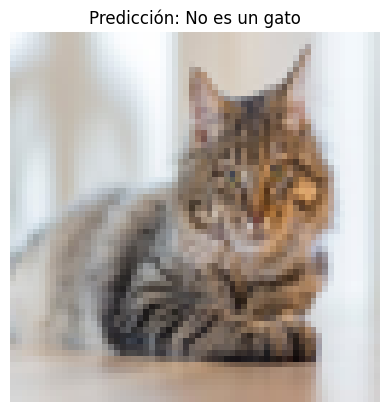

In [ ]:
# Mostrar la imagen redimensionada correctamente
plt.imshow(img_resized2)  # Utilizamos la imagen redimensionada directamente
plt.title(f"Predicción: {'Gato' if prediction[0] == 1 else 'No es un gato'}")
plt.axis("off")
plt.show()